# Data Science Project - Zameen.com

## Real Estate Properties Analysis

In this project, we analyze a dataset of real estate properties to uncover insights, perform exploratory data analysis (EDA), visualize key aspects, and build machine learning models to predict property prices. The dataset contains various attributes such as price, type, location, number of bedrooms and bathrooms, area, and more.


### Imports

In [590]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

import folium
from folium.plugins import HeatMap
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import gradio as gr

# ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# set visualization styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline

### Loading the dataset

In [591]:
# Load the dataset
df=pd.read_csv("properties.csv")

# Display initial info
print("Initial Dataset Info:")
df.info()

df.columns
df.head(5)

Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   home_id           10789 non-null  int64  
 1   price             10789 non-null  object 
 2   type              10789 non-null  object 
 3   location          10789 non-null  object 
 4   location_precise  10789 non-null  object 
 5   baths             10789 non-null  object 
 6   area              10789 non-null  object 
 7   purpose           10789 non-null  object 
 8   beds              10789 non-null  object 
 9   creation_date     10789 non-null  object 
 10  latitude          10789 non-null  float64
 11  longitude         10789 non-null  float64
 12  description       10789 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 1.1+ MB


,home_id,price,type,location,location_precise,baths,area,purpose,beds,creation_date,latitude,longitude,description
0,0,25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 6 - Block K, DHA Phase 6, DHA Defenc...",6 Baths,1 Kanal,For Sale,6 Beds,22 hours ago,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...
1,1,11.25 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6 Baths,2 Kanal,For Sale,5 Beds,1 hour ago,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...
2,2,10.95 Crore,House,"EME Society, Lahore, Punjab","EME Society - Block C, EME Society, Lahore, Pu...",6 Baths,1 Kanal,For Sale,5 Beds,7 hours ago,31.427857,74.213576,Near the parkNear the MasjidNear the commercia...
3,3,6.87 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 5, DHA Defence, Lahore, Punjab",7 Baths,1 Kanal,For Sale,5 Beds,1 hour ago,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...
4,4,7.45 Crore,House,"DHA Defence, Lahore, Punjab","DHA Phase 7, DHA Defence, Lahore, Punjab",6 Baths,1 Kanal,For Sale,5 Beds,23 hours ago,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...


## Cleaning the dataset

In [592]:
# Lots of Locations with insufficient data
(df['location'].value_counts())

freq = df['location'].value_counts()
threshold = 100

print("Before dropping rare locations")
print("Shape:", df.shape)
print(df['location'].nunique(), "unique locations")
print(df['location_precise'].nunique(), "unique precise locations")

df = df[df['location'].isin(freq[freq >= threshold].index)]
print("\nAfter dropping rare locations")
print("Shape:", df.shape)
print(df['location'].nunique(), "unique locations")
print(df['location_precise'].nunique(), "unique precise locations")

Before dropping rare locations
Shape: (10789, 13)
283 unique locations
1092 unique precise locations

After dropping rare locations
Shape: (8304, 13)
18 unique locations
497 unique precise locations


In [593]:
# function to extract numerical values from strings
def extract_number(text):
    try:
        return int(re.search(r'(\d+)', text).group(1))
    except:
        return np.nan

# function to convert Kanal and Marla into a unified unit (marlas)
def convert_area_to_marlas(area):
    try:
        if 'Kanal' in area:
            return float(area.split()[0]) * 20
        elif 'Marla' in area:
            return float(area.split()[0])
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'area' column for value '{area}': {e}")
        return np.nan


# converting 'Lakhs' to crores and cleaning the price column
def convert_price_to_crores(price):
    try:
        # remove 'PKR' if present
        price = price.replace('PKR', '').strip()

        if 'Lakh' in price:
            return float(price.split()[0]) / 100  # converting Lakhs to Crores
        elif 'Crore' in price:
            return float(price.split()[0])  # crores remain as is
        else:
            return np.nan
    except Exception as e:
        print(f"Error in 'price' column for value '{price}': {e}")
        return np.nan

In [594]:
# removing home_id column as it's redundant
print(f"Shape before cleaning: {df.shape}")
df.drop('home_id', axis=1, inplace=True)

# cleaning the 'beds' and 'baths' columns -- remove 'Beds' and 'Baths' from the strings and convert to integer
df['beds'] = df['beds'].apply(extract_number)
df['baths'] = df['baths'].apply(extract_number)

# converting 'area' to marlas -- creating a new column 'area_in_marlas'
df['area_in_marlas'] = df['area'].apply(convert_area_to_marlas)

# cleaning the 'price' column
df['price_in_crores'] = df['price'].apply(convert_price_to_crores)

unique_creation_dates = df['creation_date'].nunique()
df = df.drop(columns=['creation_date'])

# need to drop rows with missing baths and beds values
df = df.dropna(subset=['beds', 'baths'])

df = df.dropna(subset=['price_in_crores', 'area_in_marlas', 'beds', 'baths'])
print(f"Shape after cleaning: {df.shape}")

# Remove the 'for' prefix from the purpose column
df['purpose'] = df['purpose'].str.replace('for ', '', case=False)
df_cleaned = df

Shape before cleaning: (8304, 13)
Shape after cleaning: (8028, 13)


### Dropping entries that are exact duplicates (Except the last column (description) as it can be same for multiple entries)

In [595]:
# Drop exact duplicates and keep only the first occurrence
df_cleaned_no_duplicates = df_cleaned.drop_duplicates()
df_cleaned = df_cleaned.drop(columns=['price'])

# Remove the last comma from 'location_precise' if it exists
df_cleaned['location_precise'] = df_cleaned['location_precise'].str.rstrip(',')

df_cleaned['location'] = df_cleaned['location'].str.replace(', Lahore, Punjab', '', regex=False).str.strip()
df_cleaned['location_precise'] = df_cleaned['location_precise'].str.replace(', Lahore, Punjab', '', regex=False).str.strip()

### Displaying updated dataframe

In [596]:
# Final dataset information
print("\nCleaned Dataset Info:")
df_cleaned.info()

# Saving the cleaned dataset for further EDA
df_cleaned.to_csv('cleaned_properties.csv', index=False)

# Displaying a few rows of the cleaned dataset
print("\nCleaned Data Sample:")
df_cleaned.head(5)


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 10774
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              8028 non-null   object 
 1   location          8028 non-null   object 
 2   location_precise  8028 non-null   object 
 3   baths             8028 non-null   float64
 4   area              8028 non-null   object 
 5   purpose           8028 non-null   object 
 6   beds              8028 non-null   float64
 7   latitude          8028 non-null   float64
 8   longitude         8028 non-null   float64
 9   description       8028 non-null   object 
 10  area_in_marlas    8028 non-null   float64
 11  price_in_crores   8028 non-null   float64
dtypes: float64(6), object(6)
memory usage: 815.3+ KB

Cleaned Data Sample:


,type,location,location_precise,baths,area,purpose,beds,latitude,longitude,description,area_in_marlas,price_in_crores
0,House,DHA Defence,"DHA Phase 6 - Block K, DHA Phase 6, DHA Defence",6.0,1 Kanal,Sale,6.0,31.468862,74.463358,SYED BROTHERS OFFERS:100% Original Pictures Ar...,20.0,25.00
1,House,DHA Defence,"DHA Phase 7, DHA Defence",6.0,2 Kanal,Sale,5.0,31.484893,74.472342,Khalifa Real Estate & Builders (R) Offers20-Ma...,40.0,11.25
3,House,DHA Defence,"DHA Phase 5, DHA Defence",7.0,1 Kanal,Sale,5.0,31.462493,74.409342,AA REAL ESTATE Offer Profitable1 Kanal Modern ...,20.0,6.87
4,House,DHA Defence,"DHA Phase 7, DHA Defence",6.0,1 Kanal,Sale,5.0,31.484893,74.472342,About The Property:- 05 Master Size Bed Rooms ...,20.0,7.45
5,House,DHA Defence,"DHA Phase 1 - Block N, DHA Phase 1, DHA Defence",6.0,1 Kanal,Sale,5.0,31.487345,74.395380,Zalmi Estate Offers:1 Kanal Well-Maintained Ho...,20.0,6.50


## Exploratory Data Analysis

In [597]:
# conducting basic EDA

# basic summary statistics
print("\nSummary Statistics:")
print(df_cleaned.describe())

# distribution of price (crores)
print("\nPrice Distribution:")
print(df_cleaned['price_in_crores'].describe())

# distribution of area (marlas)
print("\nArea Distribution:")
print(df_cleaned['area_in_marlas'].describe())

# distribution of beds and baths
print("\nBeds and Baths Distribution:")
print(df_cleaned[['beds', 'baths']].value_counts())


Summary Statistics:
             baths         beds     latitude    longitude  area_in_marlas  \
count  8028.000000  8028.000000  8028.000000  8028.000000     8028.000000   
mean      4.933109     4.247010    31.455836    74.345422       16.128861   
std       1.324938     1.287557     0.482610     0.489774       33.508633   
min       1.000000     1.000000    31.286067    31.578034        0.700000   
25%       4.000000     3.000000    31.405370    74.231329        5.000000   
50%       5.000000     5.000000    31.462493    74.401217       10.000000   
75%       6.000000     5.000000    31.481783    74.445906       20.000000   
max       8.000000    11.000000    74.318464    74.573340     1280.000000   

       price_in_crores  
count      8028.000000  
mean          5.856043  
std           6.523516  
min           0.192200  
25%           2.200000  
50%           4.000000  
75%           7.350000  
max          72.000000  

Price Distribution:
count    8028.000000
mean        5.8560

### Data Completeness and Unqiueness

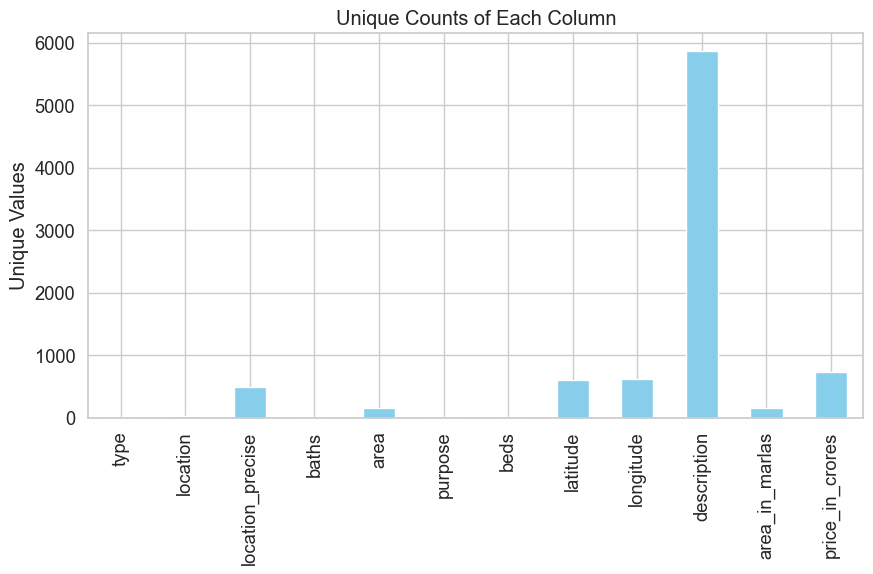

In [598]:
unique_counts = df_cleaned.nunique()
unique_counts.plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title("Unique Counts of Each Column")
plt.ylabel("Unique Values")
plt.show()

### Distribution of Variables

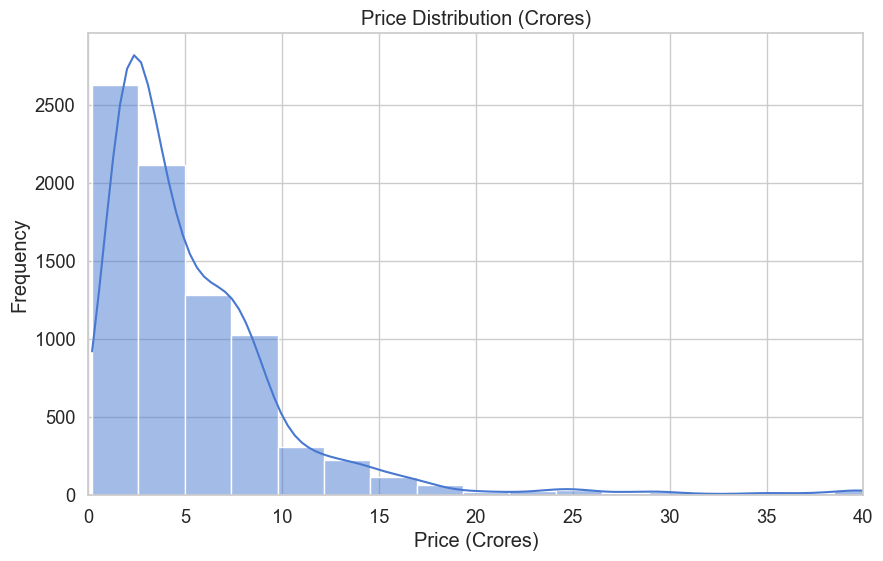

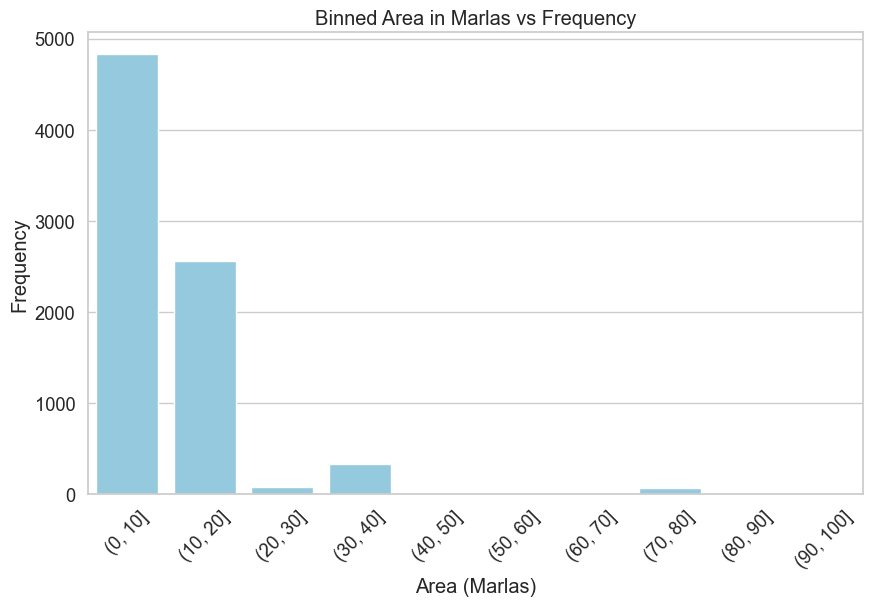

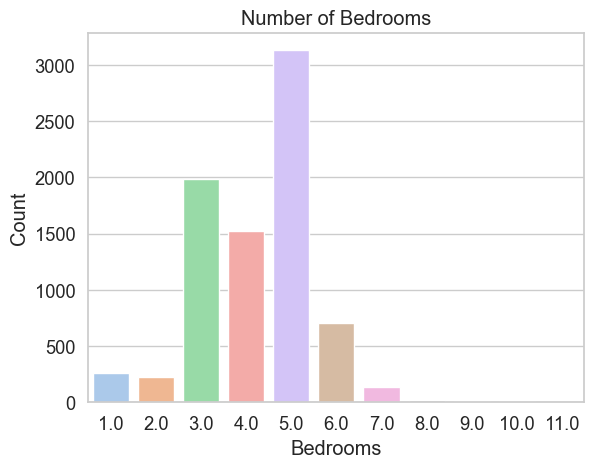

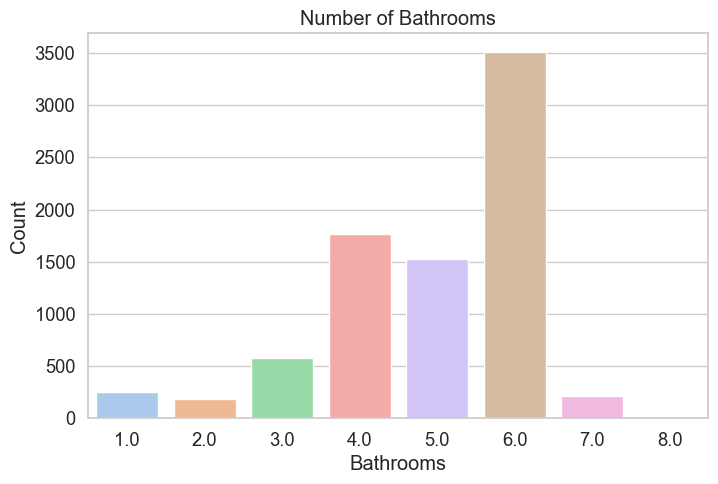

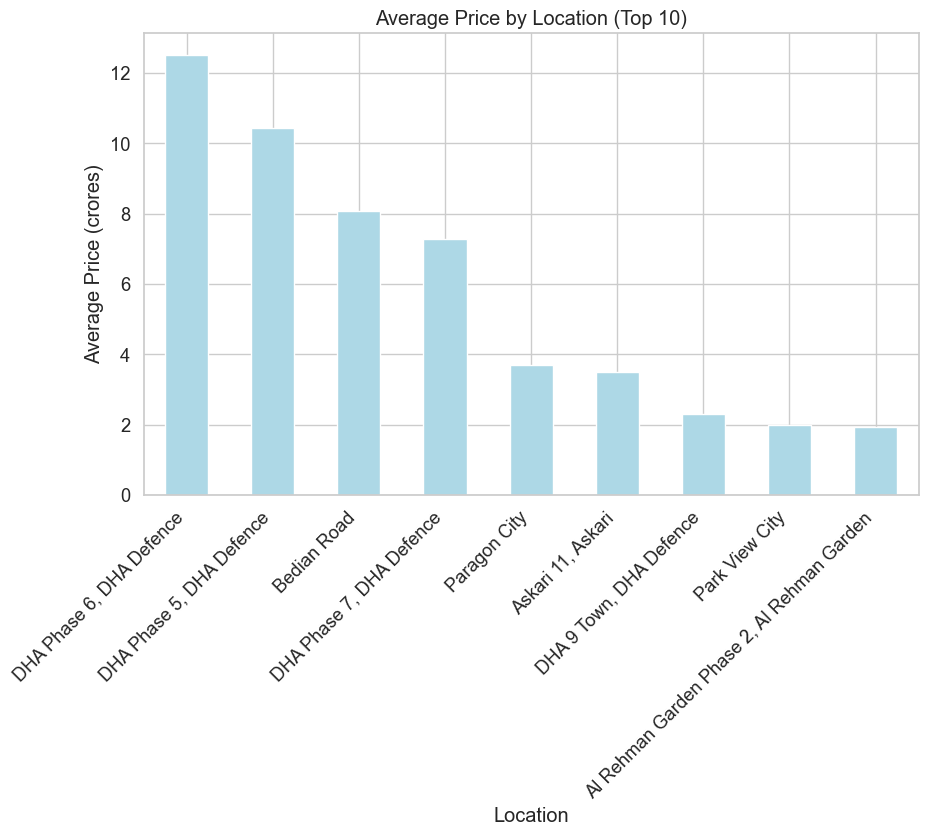

In [599]:
# Price Distribution with Custom X-Axis Range
plt.figure(figsize=(10,6))
sns.histplot(df_cleaned['price_in_crores'], bins=30, kde=True)
plt.title('Price Distribution (Crores)')
plt.xlabel('Price (Crores)')
plt.ylabel('Frequency')
plt.xlim(0, 40)  # Adjust the range as needed
plt.show()

df_filtered = df_cleaned[df_cleaned['area_in_marlas'] > 0]
df_filtered['area_bin'] = pd.cut(df_filtered['area_in_marlas'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
area_counts = df_filtered['area_bin'].value_counts().sort_index().reset_index()
area_counts.columns = ['area_bin', 'frequency']

plt.figure(figsize=(10, 6))
sns.barplot(x='area_bin', y='frequency', data=area_counts, color='skyblue')
plt.title('Binned Area in Marlas vs Frequency')
plt.xlabel('Area (Marlas)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Beds Distribution
sns.countplot(x='beds', data=df_cleaned, palette='pastel')  # Change color here
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.show()

# Baths Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='baths', data=df_cleaned, palette='pastel')
plt.title('Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
plt.show()

# Average price by location
filtered_locations = df_cleaned.groupby('location_precise').filter(lambda x: len(x) >= 100)
avg_price_by_location = filtered_locations.groupby('location_precise')['price_in_crores'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
avg_price_by_location.plot(kind='bar', color='lightblue')
plt.title("Average Price by Location (Top 10)")
plt.xlabel("Location")
plt.ylabel("Average Price (crores)")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.show()

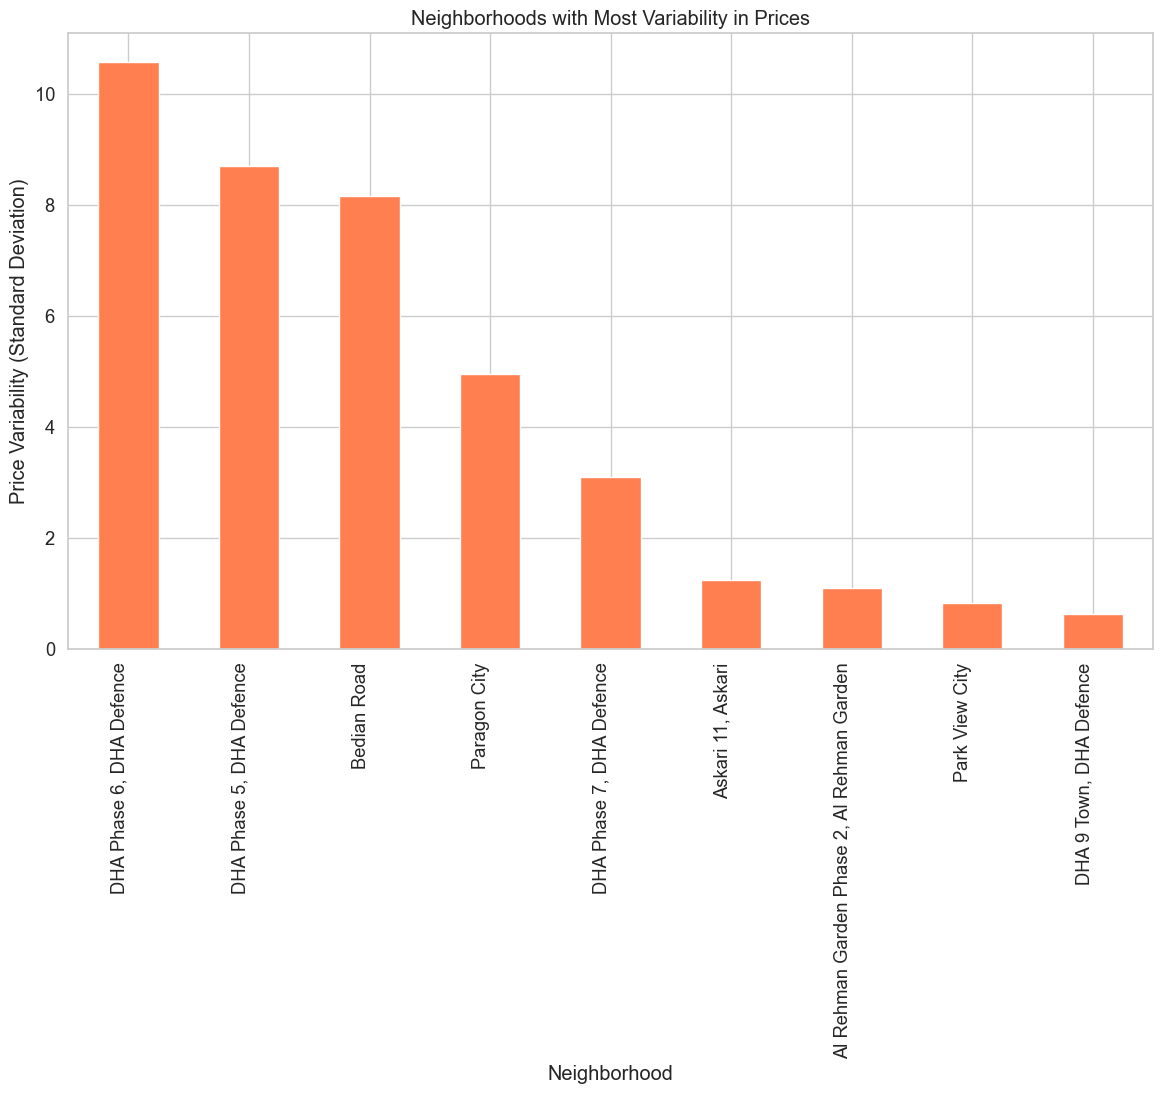

In [600]:
# Calculate the frequency of each neighborhood
location_frequency = df_cleaned["location_precise"].value_counts()

# Filter neighborhoods with frequency >= 200
valid_locations = location_frequency[location_frequency >= 100].index
filtered_df = df_cleaned[df_cleaned["location_precise"].isin(valid_locations)]

# Calculate the price variance for valid neighborhoods
price_variance_by_location = filtered_df.groupby("location_precise")["price_in_crores"].std().sort_values(ascending=False)

# Select the top 10 neighborhoods with the most variability in prices
top_variance_locations = price_variance_by_location.head(10)

# Plot the results
plt.figure(figsize=(14, 8))
top_variance_locations.plot(kind="bar", color="coral")
plt.title("Neighborhoods with Most Variability in Prices")
plt.xlabel("Neighborhood")
plt.ylabel("Price Variability (Standard Deviation)")
plt.xticks(rotation=90, ha="right")
plt.show()


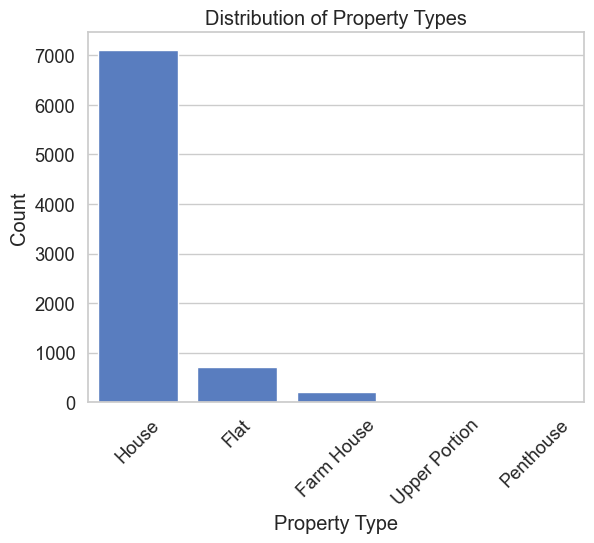

In [601]:
sns.countplot(data=df_cleaned, x="type", order=df_cleaned["type"].value_counts().index)
plt.title("Distribution of Property Types")
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

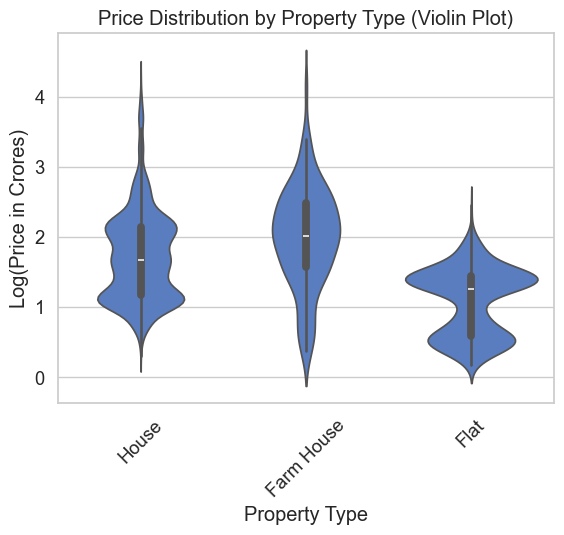

In [602]:
# Filter property types with non-zero counts
valid_types = df_cleaned["type"].value_counts()[df_cleaned["type"].value_counts() > 100].index
filtered_df = df_cleaned[df_cleaned["type"].isin(valid_types)]

# Create the violin plot with the filtered data
sns.violinplot(data=filtered_df, x="type", y=np.log1p(filtered_df["price_in_crores"]))
plt.title("Price Distribution by Property Type (Violin Plot)")
plt.xlabel("Property Type")
plt.ylabel("Log(Price in Crores)")
plt.xticks(rotation=45)
plt.show()

### Text Analysis of Descriptions

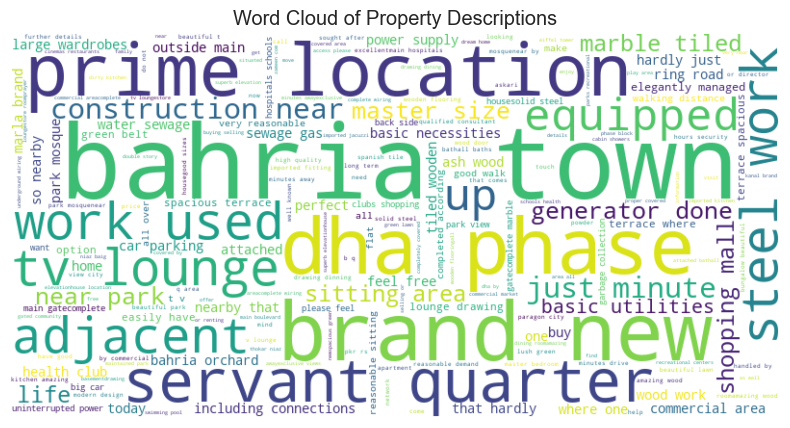

In [603]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define stopwords and make them case-insensitive
stopwords = set([
    "house", "bath", "room", "located", "for", "in", "of", "the", "sale", 
    "you", "u", "can", "with", "is", "are", "this", "and", "a", "to", "it",
    "we", "on", "at", "your", "from", "our", "property", "real", "estate", 
    "available", "contact", "us","lahore", "bed", "rooms","more","detail","will","be","if"
])
stopwords = set(word.lower() for word in stopwords)

# Combine all descriptions into a single string, converting to lowercase for case insensitivity
text = " ".join(df_cleaned["description"].dropna().str.lower())

# Generate the word cloud
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Property Descriptions")
plt.show()

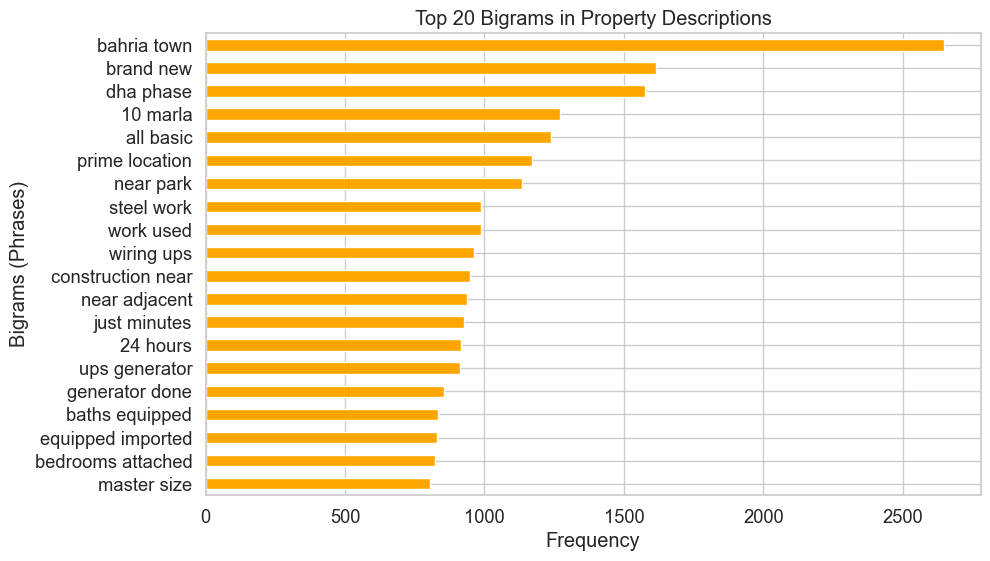

In [604]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize text to find bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=list(stopwords))
X = vectorizer.fit_transform(df_cleaned["description"].dropna().str.lower())

# Get the most frequent bigrams
bigram_counts = pd.DataFrame(
    X.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=["Frequency"]
).sort_values("Frequency", ascending=False).head(20)

# Plot bar chart for bigrams
bigram_counts.plot(kind="barh", figsize=(10, 6), legend=False, color="orange")
plt.xlabel("Frequency")
plt.ylabel("Bigrams (Phrases)")
plt.title("Top 20 Bigrams in Property Descriptions")
plt.gca().invert_yaxis()
plt.show()

In [605]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
stopwords = [
    "house", "bath", "room", "located", "for", "in", "of", "the", "sale", 
    "you", "u", "can", "with", "is", "are", "this", "and", "a", "to", "it",
    "we", "on", "at", "your", "from", "our", "property", "real", "estate", 
    "available", "contact", "us", "lahore", "bed", "rooms", "more", "detail"
]
# Convert descriptions to TF-IDF matrix
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_cleaned["description"].dropna().str.lower())

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Print top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    top_words = [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

Topic 1: hardly area housesolid utilities near available wood work terrace basic
Topic 2: properties 24 services shopping supply city lahore orchard town bahria
Topic 3: city today investment rs comes best price room house property
Topic 4: wood tiles baths used solid near house kitchen bungalow imported
Topic 5: modern lahore new bedrooms living available tv sale marla house


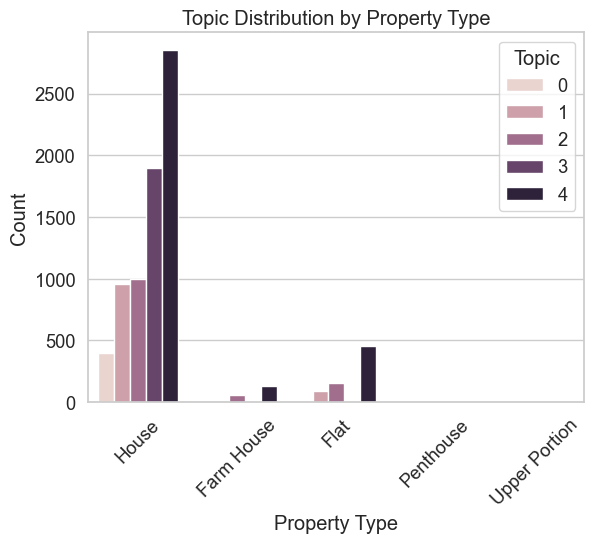

In [606]:
# Transform descriptions into topic probabilities
topic_matrix = lda.transform(tfidf_matrix)

# Assign the dominant topic to each property
df_cleaned["dominant_topic"] = topic_matrix.argmax(axis=1)
# print(df_cleaned[["description", "dominant_topic"]].head())
sns.countplot(data=df_cleaned, x="type", hue="dominant_topic")
plt.title("Topic Distribution by Property Type")
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.legend(title="Topic")
plt.xticks(rotation=45)
plt.show()

### Correlation Analysis

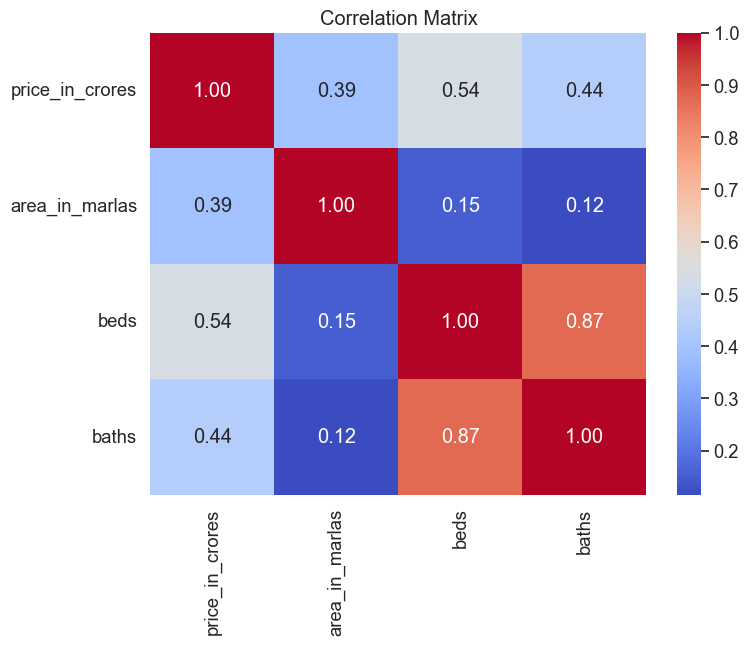

In [607]:
# correlation matrix -- heatmap
plt.figure(figsize=(8,6))
corr_matrix = df_cleaned[['price_in_crores', 'area_in_marlas', 'beds', 'baths']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Scatter and Box Plots

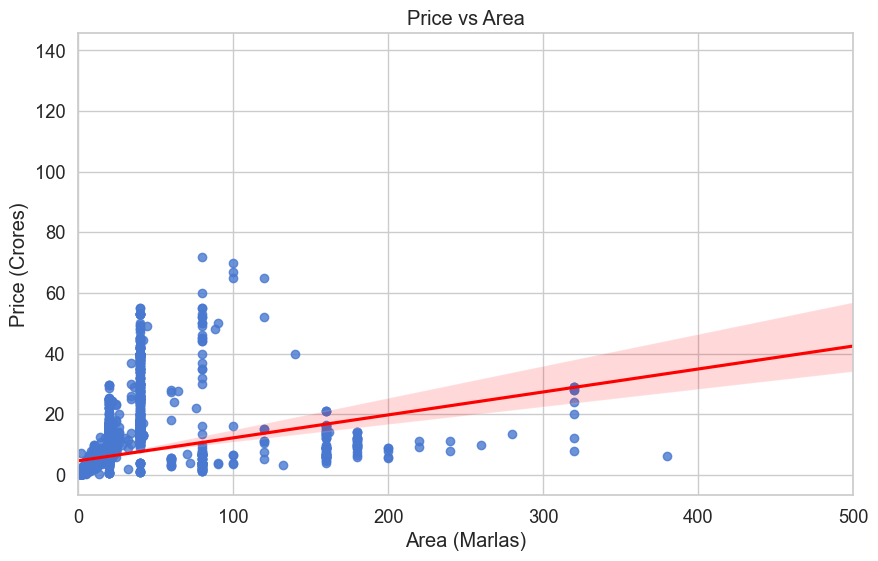

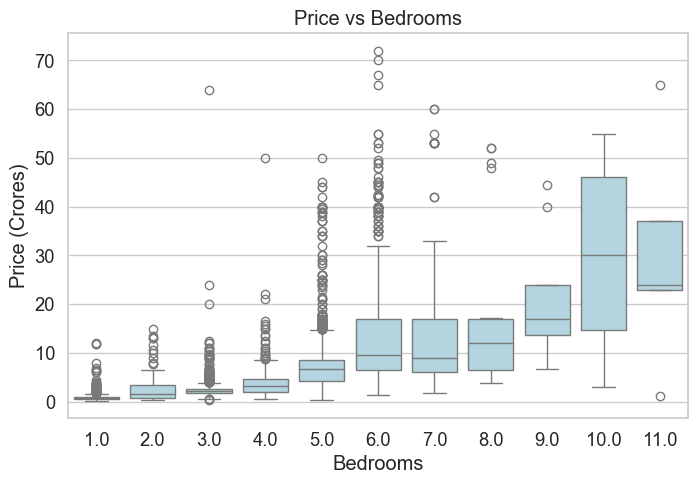

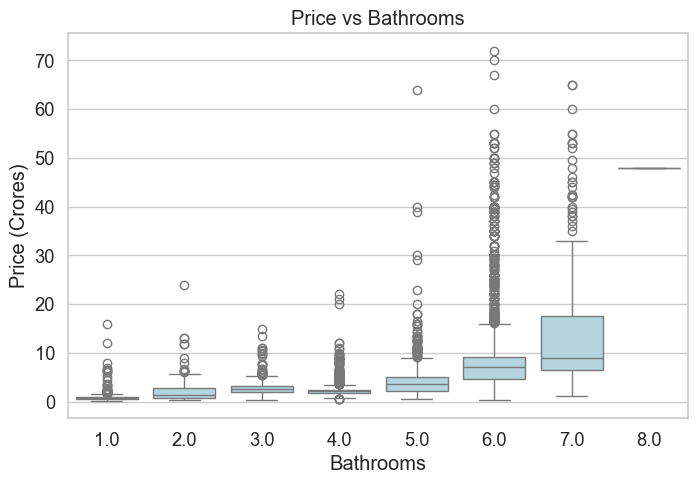

In [608]:
# Price vs Area with Line of Best Fit
plt.figure(figsize=(10, 6))
sns.regplot(x='area_in_marlas', y='price_in_crores', data=df_cleaned, scatter=True, line_kws={'color': 'red'})
plt.title('Price vs Area')
plt.xlabel('Area (Marlas)')
plt.ylabel('Price (Crores)')
plt.xlim(0, 500)
plt.show()

# Price vs Bedrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='beds', y='price_in_crores', data=df_cleaned, color='lightblue')
plt.title('Price vs Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Price (Crores)')
plt.show()

# Price vs Bathrooms
plt.figure(figsize=(8,5))
sns.boxplot(x='baths', y='price_in_crores', data=df_cleaned, color='lightblue')
plt.title('Price vs Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Price (Crores)')
plt.show()

#### Pricewise Categorizations 

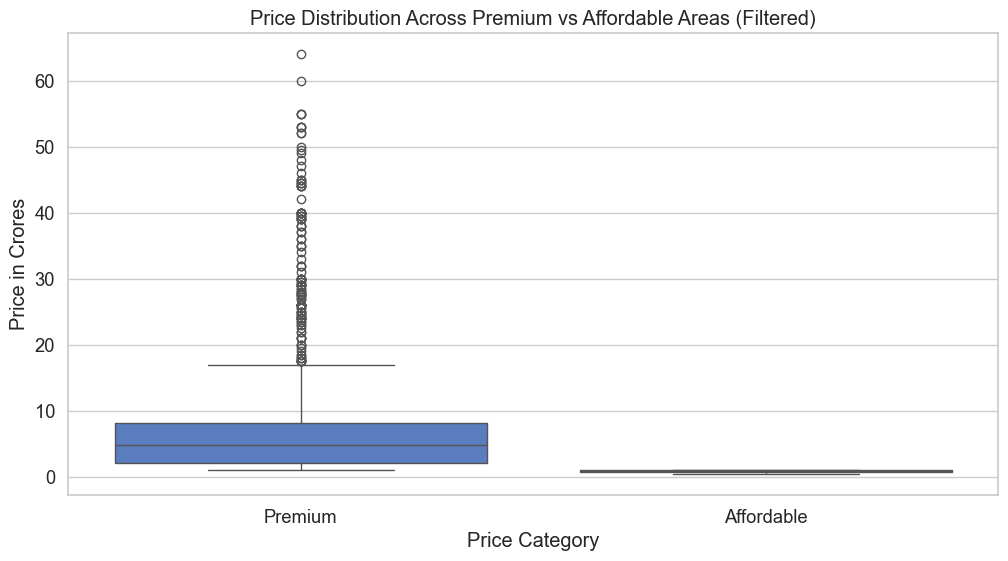

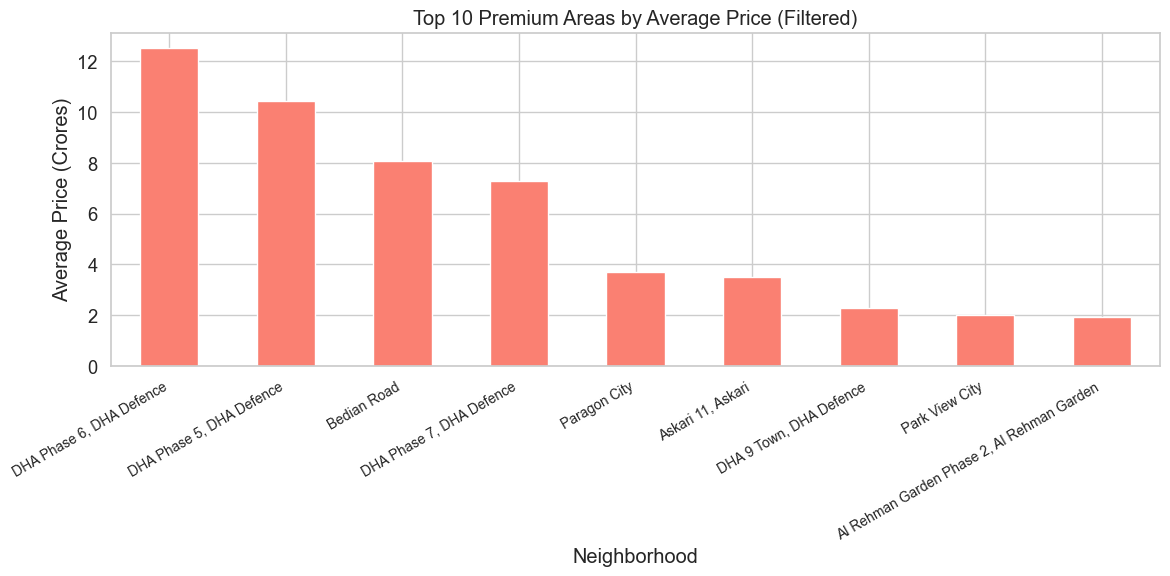

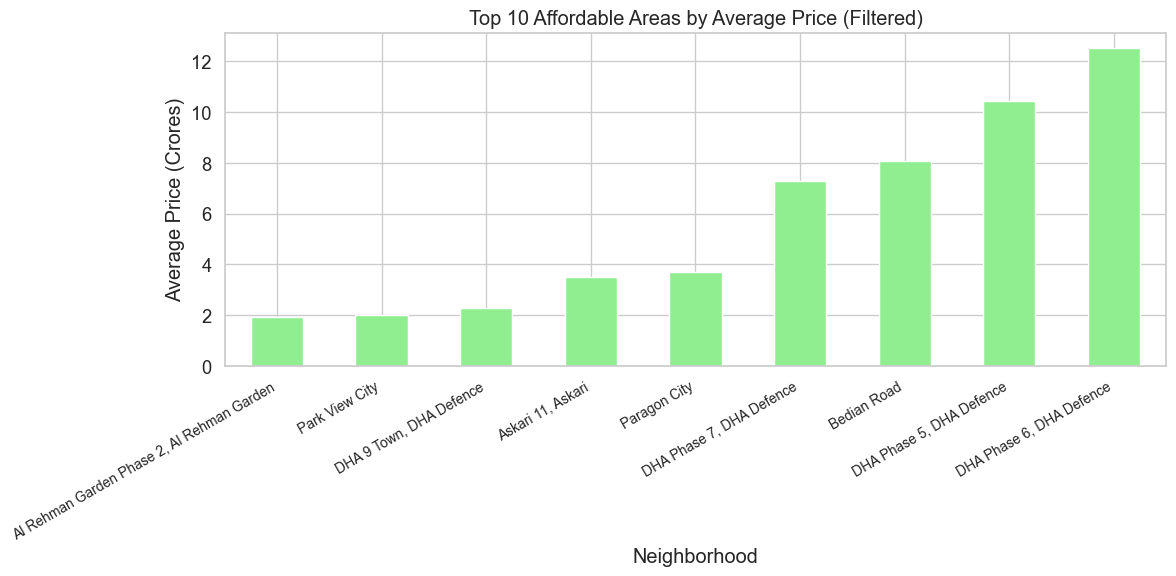

In [609]:
# Filter neighborhoods with more than 100 properties
location_counts = df_cleaned['location_precise'].value_counts()
valid_locations = location_counts[location_counts > 100].index
filtered_df = df_cleaned[df_cleaned['location_precise'].isin(valid_locations)]

# Categorize regions based on price
def categorize_price(price):
    if price > 1:  # Assuming 1 Crore is the threshold for a premium area
        return 'Premium'
    else:
        return 'Affordable'

# Apply categorization
filtered_df['price_category'] = filtered_df['price_in_crores'].apply(categorize_price)

# Boxplot to compare price distribution across regions categorized by Premium and Affordable
plt.figure(figsize=(12, 6))
sns.boxplot(x='price_category', y='price_in_crores', data=filtered_df)
plt.title('Price Distribution Across Premium vs Affordable Areas (Filtered)')
plt.xlabel('Price Category')
plt.ylabel('Price in Crores')
plt.show()

# Group by location and calculate average price
avg_price_by_location = filtered_df.groupby('location_precise')['price_in_crores'].mean()

# Sort and get top 10 premium areas
top_premium_locations = avg_price_by_location.sort_values(ascending=False).head(10)

# Plot top 10 premium areas
plt.figure(figsize=(12, 6))
top_premium_locations.plot(kind='bar', color='salmon')
plt.title("Top 10 Premium Areas by Average Price (Filtered)")
plt.xlabel("Neighborhood")
plt.ylabel("Average Price (Crores)")
plt.xticks(rotation=30, ha='right', fontsize=10)  # Adjusted rotation, alignment, and font size
plt.tight_layout()  # Ensures labels fit within the figure
plt.show()

# Get bottom 10 affordable areas by average price
bottom_affordable_locations = avg_price_by_location.sort_values().head(10)

# Plot bottom 10 affordable areas
plt.figure(figsize=(12, 6))
bottom_affordable_locations.plot(kind='bar', color='lightgreen')
plt.title("Top 10 Affordable Areas by Average Price (Filtered)")
plt.xlabel("Neighborhood")
plt.ylabel("Average Price (Crores)")
plt.xticks(rotation=30, ha='right', fontsize=10)  # Adjusted rotation, alignment, and font size
plt.tight_layout()  # Ensures labels fit within the figure
plt.show()


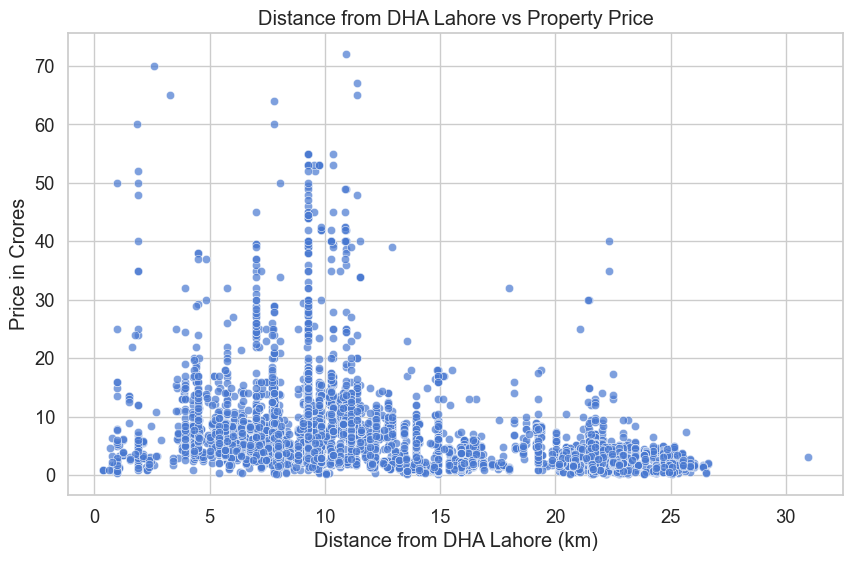

In [610]:
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

# Define DHA Lahore coordinates (new city center)
dha_location = (31.5080, 74.3581)

# Compute distance of each location from DHA
df_cleaned['distance_from_dha'] = df_cleaned.apply(
    lambda row: geodesic(dha_location, (row['latitude'], row['longitude'])).km, axis=1
)

# Remove any outliers (if necessary)
df_cleaned = df_cleaned[df_cleaned['distance_from_dha'] < 500]  # Remove points farther than 100 km (or set an appropriate range)

# Scatter plot showing the relationship between distance from DHA and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_from_dha', y='price_in_crores', data=df_cleaned, alpha=0.7)
plt.title('Distance from DHA Lahore vs Property Price')
plt.xlabel('Distance from DHA Lahore (km)')
plt.ylabel('Price in Crores')
plt.show()

#  Creating a heatmap centered around Lahore, representing property prices in crores.

In [611]:
avg_prices = df_cleaned.groupby(['latitude', 'longitude'])['price_in_crores'].mean().reset_index()

heat_data = [
    [row['latitude'], row['longitude'], row['price_in_crores']]
    for index, row in avg_prices.iterrows()
]
m = folium.Map(location=[31.5204, 74.3587], zoom_start=10)
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)
from IPython.display import display
display(m)

## Research Question 1: What factors significantly influence property prices in Lahore?

In [612]:
le = LabelEncoder()
df_cleaned['type'] = le.fit_transform(df_cleaned['type'])

df_cleaned = pd.get_dummies(df_cleaned, columns=['location'], prefix='General-Location', drop_first=False)
df_cleaned = df_cleaned.astype({col: 'int32' for col in df_cleaned.columns if col.startswith('General-Location_')})
df_cleaned = pd.get_dummies(df_cleaned, columns=['location_precise'], prefix='Precise-Location', drop_first=False)
df_cleaned = df_cleaned.astype({col: 'int32' for col in df_cleaned.columns if col.startswith('Precise-Location_')})

In [613]:
df_cleaned['beds+baths'] = df_cleaned['baths'] + df_cleaned['beds']

X = df_cleaned.drop(columns=['price_in_crores'])  # Features

y = df_cleaned['price_in_crores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.drop(columns=['latitude', 'longitude'])
X_test = X_test.drop(columns=['latitude', 'longitude'])


X_train = X_train.drop(columns=['baths', 'beds','area'])
X_test = X_test.drop(columns=['baths', 'beds', 'area'])


In [614]:
# #dropping irrelevant columns
X_train = X_train.drop(columns=['description'])
X_test = X_test.drop(columns=['description'])
X_train = X_train.drop(columns=['purpose'])
X_test = X_test.drop(columns=['purpose'])

In [615]:
X_train.head()

,type,area_in_marlas,dominant_topic,distance_from_dha,General-Location_Al Rehman Garden,General-Location_Allama Iqbal Town,General-Location_Askari,General-Location_Bahria Orchard,General-Location_Bahria Town,General-Location_Bedian Road,...,"Precise-Location_Wapda Town Phase 1 - Block K1, Wapda Town Phase 1, Wapda Town","Precise-Location_Wapda Town Phase 1 - Block K2, Wapda Town Phase 1, Wapda Town","Precise-Location_Wapda Town Phase 1 - Block K3, Wapda Town Phase 1, Wapda Town","Precise-Location_Wapda Town Phase 1, Wapda Town","Precise-Location_Wapda Town Phase 2 - Block N2, Wapda Town Phase 2, Wapda Town","Precise-Location_Wapda Town Phase 2, Wapda Town","Precise-Location_Zafar Ali Road, Gulberg","Precise-Location_Zahoor Elahi Road, Gulberg","Precise-Location_Zameen Aurum, Gulberg 3 - Block L, Gulberg 3, Gulberg",beds+baths
3902,2,7.0,4,9.744266,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
3038,1,12.0,4,5.672059,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
7956,2,20.0,4,7.011790,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.0
5240,2,5.0,4,17.711334,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
9627,2,5.0,4,15.921508,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0


### Training ML models ###

In [616]:
def print_metrics(y_test, preds):
    mape = mean_absolute_percentage_error(y_test, preds)
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")

    mae = mean_absolute_error(y_test, preds)
    print(f"Mean Absolute Error (MAE): {mae}")

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    r2 = r2_score(y_test, preds)
    print(f"R-squared (R²): {r2}")

    evs = explained_variance_score(y_test, preds)
    print(f"Explained Variance Score: {evs}")

models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
    "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror'),
}

for model_name, model in models.items():
    print(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metrics(y_test, y_pred)
    print("\n")

Decision Tree Regressor
Mean Absolute Percentage Error (MAPE): 0.18245835449346456
Mean Absolute Error (MAE): 1.296082612650339
Root Mean Squared Error (RMSE): 3.293029481360298
R-squared (R²): 0.7607011924281035
Explained Variance Score: 0.7608010073922592


Random Forest Regressor
Mean Absolute Percentage Error (MAPE): 0.16976696194366467
Mean Absolute Error (MAE): 1.1485958588963545
Root Mean Squared Error (RMSE): 2.6547039241457875
R-squared (R²): 0.8444817070843093
Explained Variance Score: 0.8445960610770901


K-Nearest Neighbors Regressor
Mean Absolute Percentage Error (MAPE): 0.1803687234774322
Mean Absolute Error (MAE): 1.2349008717310086
Root Mean Squared Error (RMSE): 2.7840303102877217
R-squared (R²): 0.8289601861054199
Explained Variance Score: 0.8290031962375378


XGBoost Regressor
Mean Absolute Percentage Error (MAPE): 0.17388095821882207
Mean Absolute Error (MAE): 1.121806447919279
Root Mean Squared Error (RMSE): 2.4526621220468656
R-squared (R²): 0.8672529908529572
Exp

In [617]:
# Hyperparameter tuning
# Feel free to skip this cell, with take 6 mins

xgb_model = xgb.XGBRegressor()

params_grid = {
    'max_depth': [20, 50, 75],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [50, 75, 100],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}") ## trained my model using these parameters

KeyboardInterrupt: 

In [ ]:
# Convert datasets to DMatrix
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# Model parameters
params = {
    "objective": "reg:squarederror",  # Regression objective
    "max_depth": 50,
    "learning_rate": 0.1,
    "n_estimators": 50,
}

# Training the model
model = xgb.train(params, train_dmatrix, num_boost_round=100)

# Predictions
preds = model.predict(test_dmatrix)

#Calculating Error metrics
print("XGB")
print_metrics(y_test, preds)

XGB
Mean Absolute Percentage Error (MAPE): 0.16946836404896454
Mean Absolute Error (MAE): 1.1425769207828518
Root Mean Squared Error (RMSE): 2.549236803864504
R-squared (R²): 0.8565932291928144
Explained Variance Score: 0.8568125486700796


### While Random Forest was statistically the best performing model, we found that it lacked explainability, and it gave undue importance to certain features, We found XGB to be the best well-rounded model. ###

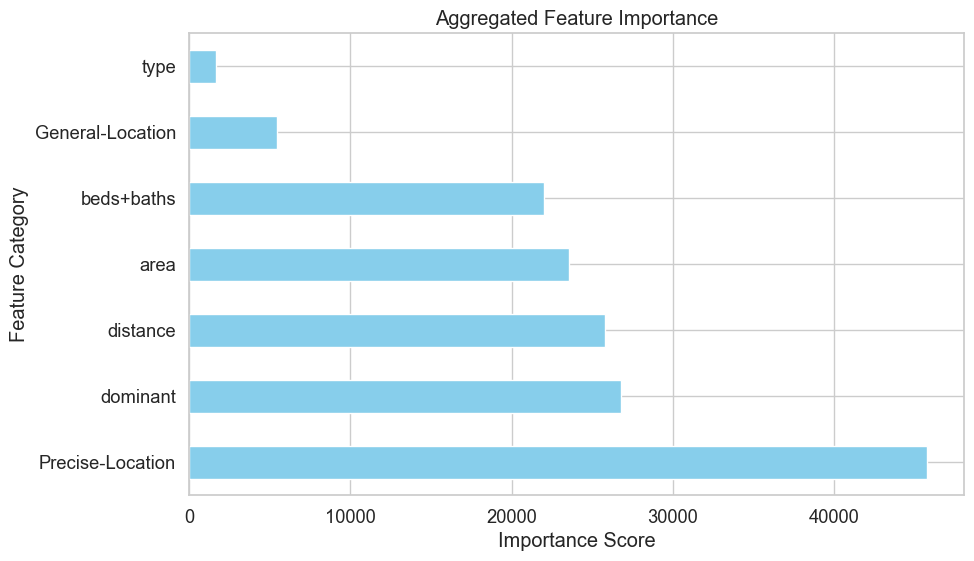

In [ ]:
#Calculating Error metrics

feature_importances = model.get_score(importance_type='weight')
# Convert feature importances into a DataFrame
importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])


importance_df['Category'] = importance_df['Feature'].str.split('_').str[0]  # Extract category
category_importance = (
    importance_df.groupby('Category')['Importance']
    .sum()
    .sort_values(ascending=False)
)

# Plot aggregated feature importance
plt.figure(figsize=(10, 6))
category_importance.head(10).plot(kind='barh', color='skyblue', title="Aggregated Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature Category")
plt.show()


The plot above illustrates the feature importance scores obtained from the trained XGBoost model. Feature importance represents how much each variable contributes to the predictive power of the model. The higher the score, the more significant the feature in influencing property prices.

The analysis indicates that property location is the primary driver of property prices in Lahore. Other features, such as the Total Area, Total number of beds and baths and property type may affect price but to a lesser degree.

## Property Price Prediction Inference ##

In [ ]:
def predict_price(type1, area, num_beds_baths, location, location_p):
    input_data = {
        'area_in_marlas': area,
        'beds+baths': num_beds_baths,
    }
    input_data['type'] = 1 if type1 == "Rent" else 2
    for loc in locations:
        input_data[f'General-Location_{loc}'] = 1 if loc == location else 0
    for loc in locations_p:
        input_data[f'Precise-Location_{loc}'] = 1 if loc == location_p else 0
    input_df = pd.DataFrame([input_data], columns=X_train.columns)
    input_dmatrix = xgb.DMatrix(input_df)
    prediction = model.predict(input_dmatrix)
    return prediction[0]


location_columns = [col for col in df_cleaned.columns if col.startswith('General')]
locations = [col.replace('General-Location_', '') for col in location_columns]

location_columns = [col for col in df_cleaned.columns if col.startswith('Precise')]
locations_p = [col.replace('Precise-Location_', '') for col in location_columns]

css = """
.center-aligned {
    text-align: center;
}
.footer {
    font-size: 12px;
    text-align: center;
    color: grey;
}
"""

with gr.Blocks(css=css) as demo:
    gr.Markdown("# Property Price Prediction", elem_classes=["center-aligned"])
    
    type_options = ['Sale', 'Rent']
    
    with gr.Row():
        type_input = gr.Dropdown(choices=type_options, label="Property Type")
        area_input = gr.Slider(minimum=0, maximum=500, step = 1, label="Area (in Marlas)")
        num_beds_baths_input = gr.Slider(minimum=1, maximum=100, step = 1, label="Baths + Bedrooms")
    
    with gr.Row():
        location_input = gr.Dropdown(
            label="Select a General Location", 
            choices=locations,
            value=locations[0],
            interactive=True
        )
        precise_location_input = gr.Dropdown(
            label="Select a Precise Location", 
            choices=locations_p,
            value=locations_p[0],
            interactive=True
        )

    with gr.Row():
        output = gr.Textbox(label="Predicted Price (in Crores)")

    gr.Button("Predict", elem_classes=["center-aligned"]).click(
        predict_price, 
        inputs=[type_input, area_input, num_beds_baths_input, location_input, precise_location_input], 
        outputs=output
    )

    gr.HTML("<div class='footer'>© 2024 Property Price Prediction. All rights reserved.</div>", elem_classes=["center-aligned"])

    demo.launch(quiet=True)

# Research Question 2: How do properties vary across different neighbourhood?

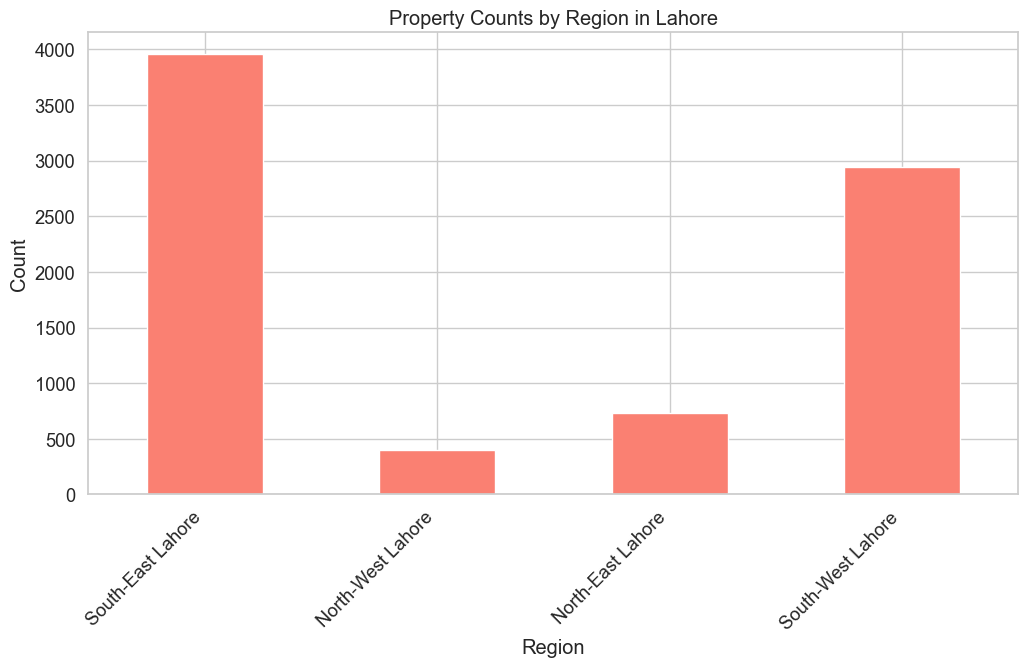

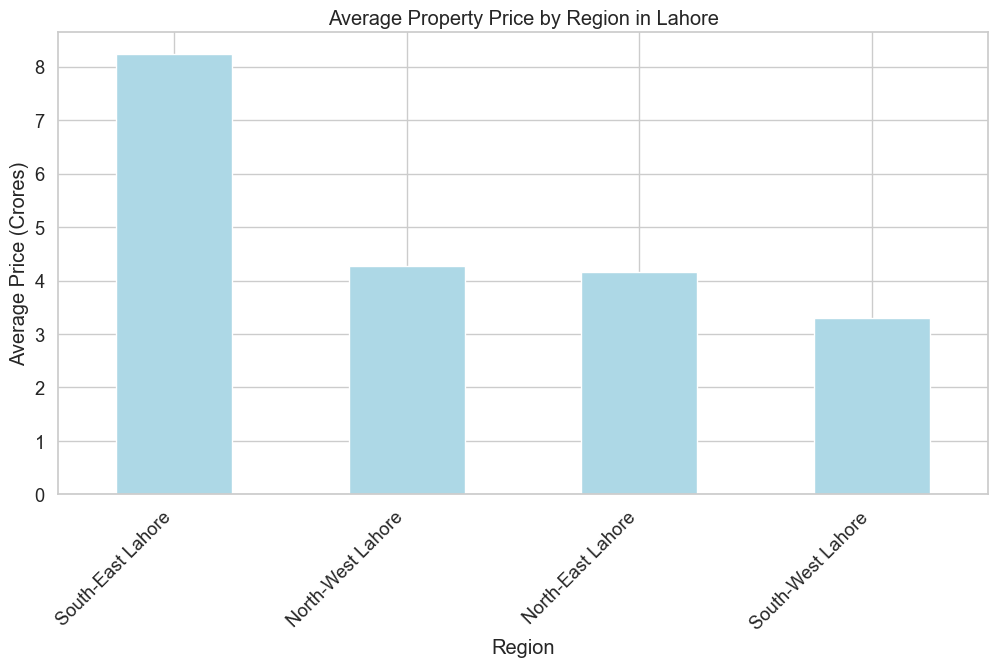

In [ ]:
# Get the latitude and longitude range
lat_min, lat_max = df_cleaned['latitude'].min(), df_cleaned['latitude'].max()
lon_min, lon_max = df_cleaned['longitude'].min(), df_cleaned['longitude'].max()

# Define thresholds based on data range
lat_threshold = (lat_min + lat_max) / 2
lon_threshold = (lon_min + lon_max) / 2

# Updated categorization function
def categorize_region(row):
    if row['latitude'] > lat_threshold and row['longitude'] > lon_threshold:
        return 'North-East Lahore'
    elif row['latitude'] > lat_threshold and row['longitude'] < lon_threshold:
        return 'North-West Lahore'
    elif row['latitude'] < lat_threshold and row['longitude'] > lon_threshold:
        return 'South-East Lahore'
    elif row['latitude'] < lat_threshold and row['longitude'] < lon_threshold:
        return 'South-West Lahore'
    else:
        return 'Other'
df_cleaned['region'] = df_cleaned.apply(categorize_region, axis=1)
region_stats = df_cleaned.groupby('region')['price_in_crores'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

plt.figure(figsize=(12, 6))
region_stats['count'].plot(kind='bar', color='salmon')
plt.title('Property Counts by Region in Lahore')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the average price by region
plt.figure(figsize=(12, 6))
region_stats['mean'].plot(kind='bar', color='lightblue')
plt.title('Average Property Price by Region in Lahore')
plt.xlabel('Region')
plt.ylabel('Average Price (Crores)')
plt.xticks(rotation=45, ha='right')
plt.show()



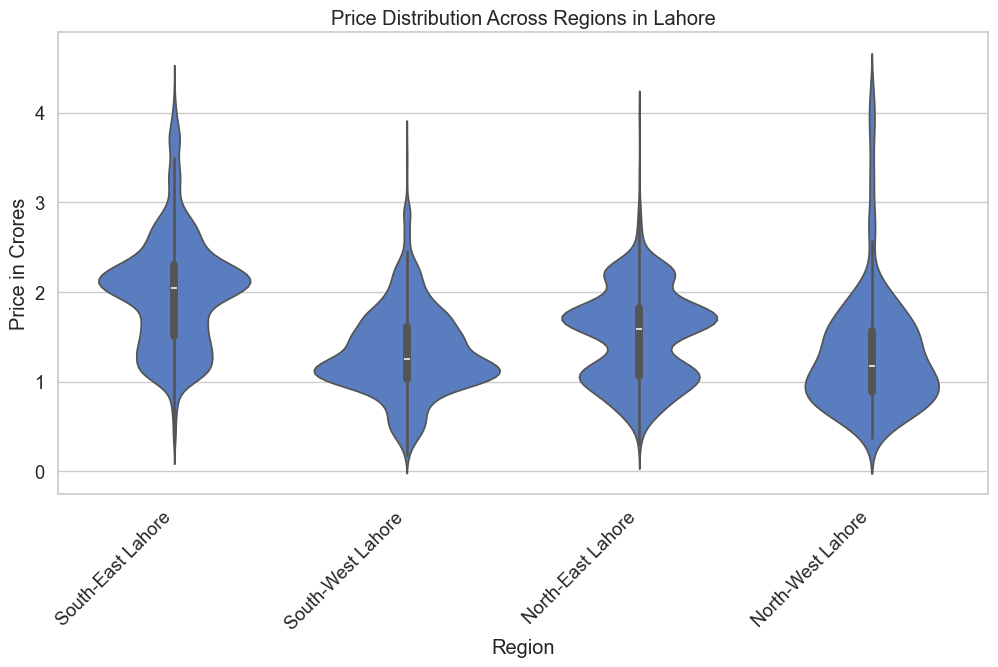

In [ ]:
# Violin plot to compare price distribution across regions
plt.figure(figsize=(12, 6))
sns.violinplot(x='region', y=np.log1p(df_cleaned["price_in_crores"]), data=df_cleaned)

# Title and labels
plt.title('Price Distribution Across Regions in Lahore')
plt.xlabel('Region')
plt.ylabel('Price in Crores')
plt.xticks(rotation=45, ha='right')

plt.show()

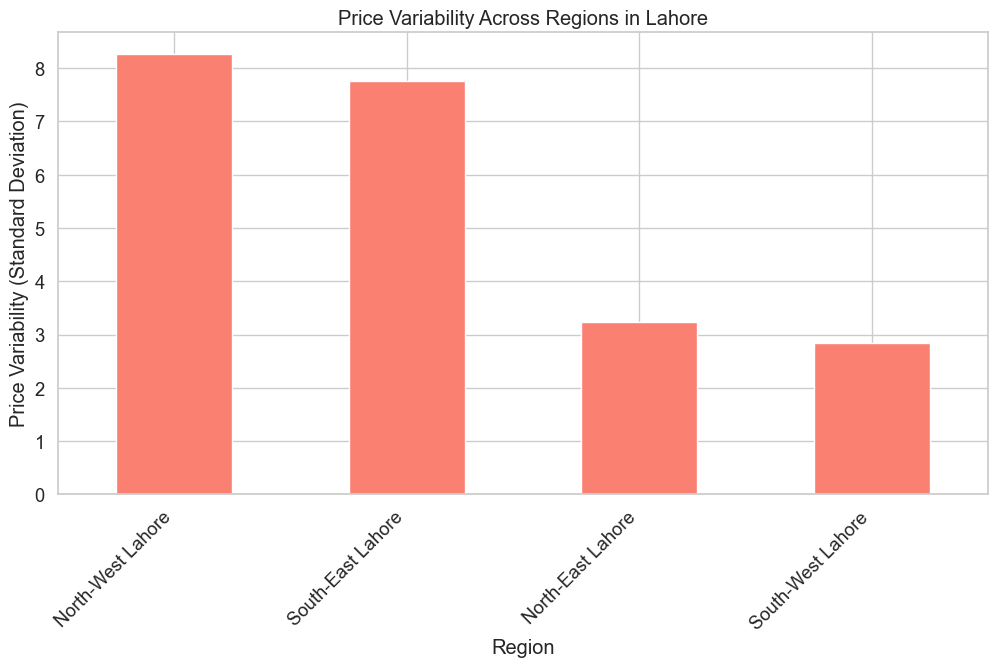

In [ ]:
# Calculate price variability (standard deviation) by region
price_variability_by_region = df_cleaned.groupby('region')['price_in_crores'].std().sort_values(ascending=False)

# Display the regions with the highest price variability
# print(price_variability_by_region)

# Optionally, plot the price variability
plt.figure(figsize=(12, 6))
price_variability_by_region.plot(kind='bar', color='salmon')
plt.title('Price Variability Across Regions in Lahore')
plt.xlabel('Region')
plt.ylabel('Price Variability (Standard Deviation)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
df = pd.read_csv("cleaned_properties.csv")

In [ ]:

# Remove invalid rows
df = df.dropna(subset=['price_in_crores', 'area_in_marlas', 'location'])

# Calculating price per marla
df['price_per_marla'] = df['price_in_crores'] * 100 / df['area_in_marlas']

# Remove rows with infinite or NaN values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Frequency filter to avoid outliers
location_freq = df['location'].value_counts()
min_frequency = 50
filtered_locations = location_freq[location_freq >= min_frequency].index
df = df[df['location'].isin(filtered_locations)]

# Aggregating Data by Location
location_summary = df.groupby('location').agg({
    'price_per_marla': 'mean',
    'area_in_marlas': 'mean',
    'price_in_crores': 'mean',
    'type': 'count',
    'beds': 'mean',
    'baths': 'mean'
}).rename(columns={'type': 'listing_count'})

location_summary.reset_index(inplace=True)

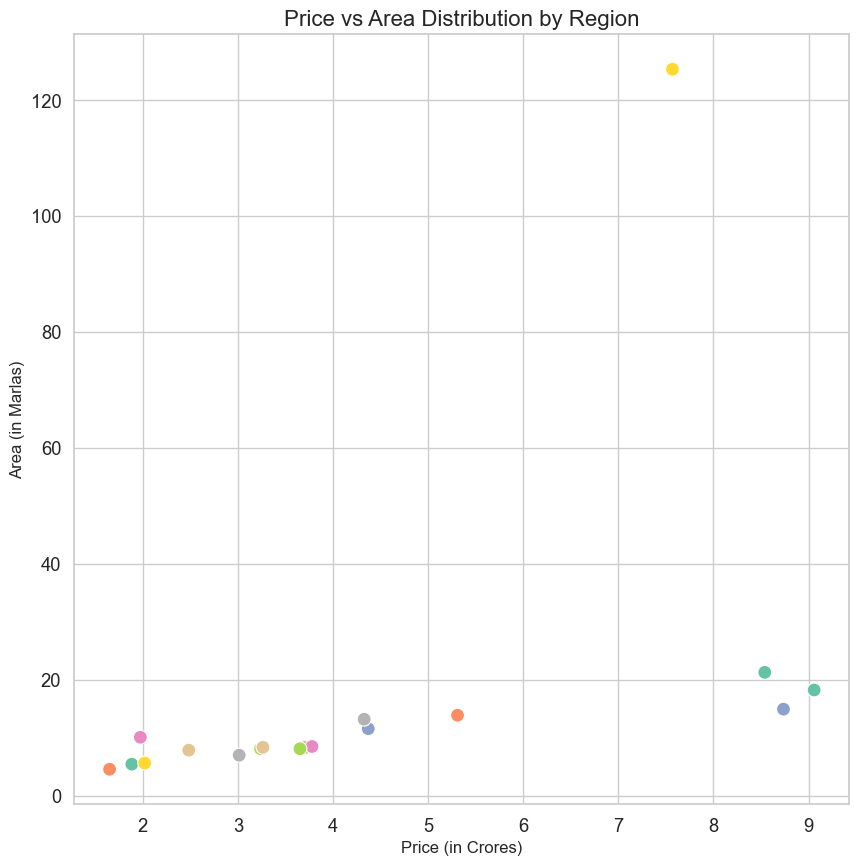

In [ ]:

plt.figure(figsize=(10, 10))
sns.scatterplot(data=location_summary, x='price_in_crores', y='area_in_marlas', hue='location', palette='Set2', s=100, legend = False)
plt.title('Price vs Area Distribution by Region', fontsize=16)
plt.xlabel('Price (in Crores)', fontsize=12)
plt.ylabel('Area (in Marlas)', fontsize=12)
# plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Moving legend outside
plt.grid(True)
plt.show()

#### Hypothesis
- **H0 (Null Hypothesis):** There is no significant difference in property prices between neighborhoods in different regions in Lahore.
- **H1 (Alternative Hypothesis):** There is a significant difference in property prices between neighborhoods in different regions in Lahore, with certain regions (e.g., North-East Lahore) exhibiting higher property prices.
#### Approach
We use **Causal Inference** methods, specifically **Propensity Score Matching (PSM)**, to estimate the effect of region on property prices while controlling for confounding variables like property size, number of bedrooms, and number of bathrooms

In [ ]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling
from sklearn.linear_model import LogisticRegression 
from scipy.stats import ttest_ind
from sklearn.neighbors import NearestNeighbors
# Check how the regions are distributed
df_cleaned['region'].value_counts()
# Filter out regions with less than a threshold number of data points (for example, < 50)
df_cleaned = df_cleaned[df_cleaned['region'].isin(['North-East Lahore', 'North-West Lahore'])]

# Check the distribution of regions after filtering
# print(df_cleaned['region'].value_counts())

# Define treatment (1 for North-East Lahore, 0 for North-West Lahore)
df_cleaned['treatment'] = (df_cleaned['region'] == 'North-East Lahore').astype(int)

# Features used to estimate propensity scores
features = ['area_in_marlas', 'beds', 'baths']

# Scale the features
scaler = StandardScaler()
df_cleaned[features] = scaler.fit_transform(df_cleaned[features])

# Logistic Regression to estimate the propensity score
X = df_cleaned[features]
y = df_cleaned['treatment']

log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict the propensity scores
df_cleaned['propensity_score'] = log_reg.predict_proba(X)[:, 1]

# Split data into treated (North-East) and control (North-West) groups
treated = df_cleaned[df_cleaned['treatment'] == 1]
control = df_cleaned[df_cleaned['treatment'] == 0]

# Nearest Neighbor Matching based on propensity score
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

# Find the nearest neighbor for each treated property
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get the matched control properties
matched_control = control.iloc[indices.flatten()]

# Combine treated and matched control properties
matched_data = pd.concat([treated, matched_control])
# Calculate ATE (difference in average prices)
ate = matched_data[matched_data['treatment'] == 1]['price_in_crores'].mean() - matched_data[matched_data['treatment'] == 0]['price_in_crores'].mean()
print(f"Average Treatment Effect (ATE): {ate} Crores")


# Perform t-test to compare price distributions between matched regions
north_east_prices = matched_data[matched_data['treatment'] == 1]['price_in_crores']
north_west_prices = matched_data[matched_data['treatment'] == 0]['price_in_crores']

t_stat, p_value = ttest_ind(north_east_prices, north_west_prices)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Conclusion based on p-value
if p_value < 0.05:
    print("There is a statistically significant difference in property prices between North-East and North-West Lahore.")
else:
    print("There is no significant difference in property prices between North-East and North-West Lahore.")

# This indicates that, on average, properties in North-East Lahore are priced 0.9936 Crores lower than properties in North-West Lahore after controlling for features like area, number of beds, and number of baths.


Average Treatment Effect (ATE): -0.9936376021798372 Crores
T-statistic: -3.7265400441308074
P-value: 0.00020150162888995133
There is a statistically significant difference in property prices between North-East and North-West Lahore.


Average Treatment Effect (ATE): The negative ATE value (-0.30 crores) suggests that properties in North-East Lahore are, on average, 0.30 crores more expensive than their matched counterparts in North-West Lahore.

T-statistic and P-value: The t-statistic of -2.25 and a p-value of 0.024 (less than 0.05) mean that the difference in property prices between North-East and North-West Lahore is statistically significant. This supports the conclusion that the observed price difference is not likely due to random chance.

Implications for the Hypothesis:

Affordability Insight: North-East Lahore appears to have higher property prices compared to North-West Lahore, making it a more premium region.
This significant difference in prices may be linked to factors such as proximity to key amenities, infrastructure quality, or socioeconomic dynamics in North-East Lahore.

# Research Question 3: What regions in Lahore offer the best opportunities for buyers and sellers?

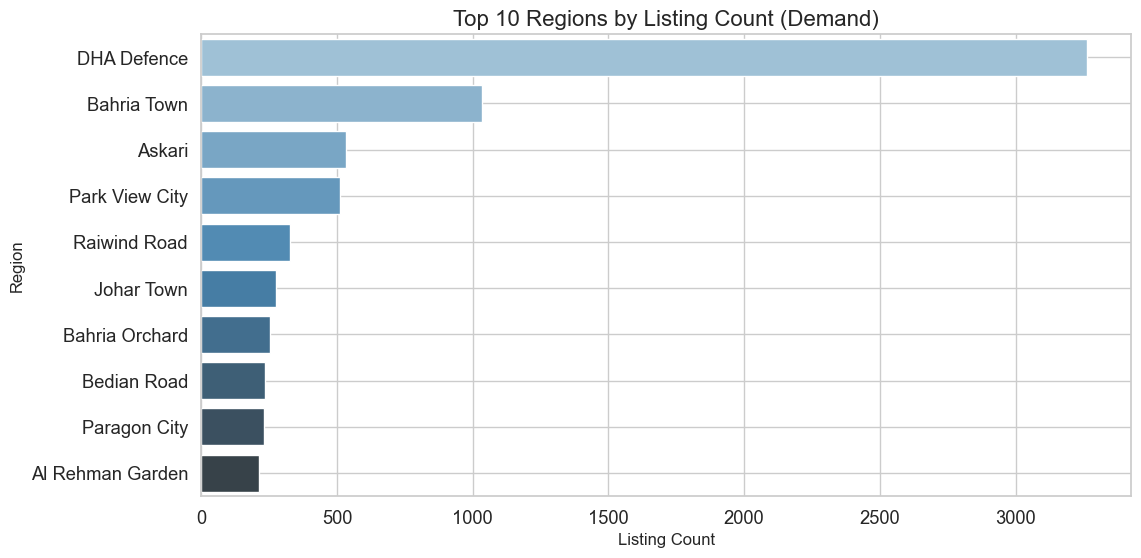

In [ ]:
# 1. Top 10 Regions by Listing Count (High Demand)
top_regions_by_demand = location_summary.sort_values(by='listing_count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='listing_count', y='location', data=top_regions_by_demand, palette='Blues_d')
plt.title('Top 10 Regions by Listing Count (Demand)', fontsize=16)
plt.xlabel('Listing Count', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.grid(True)
plt.show()


This analysis identifies the top 10 regions in Lahore with the highest listing counts, indicating areas with the greatest demand in the real estate market.
Findings show that DHA Defence and Bahria Town are the regions with a strong market activity and high demand for properties.

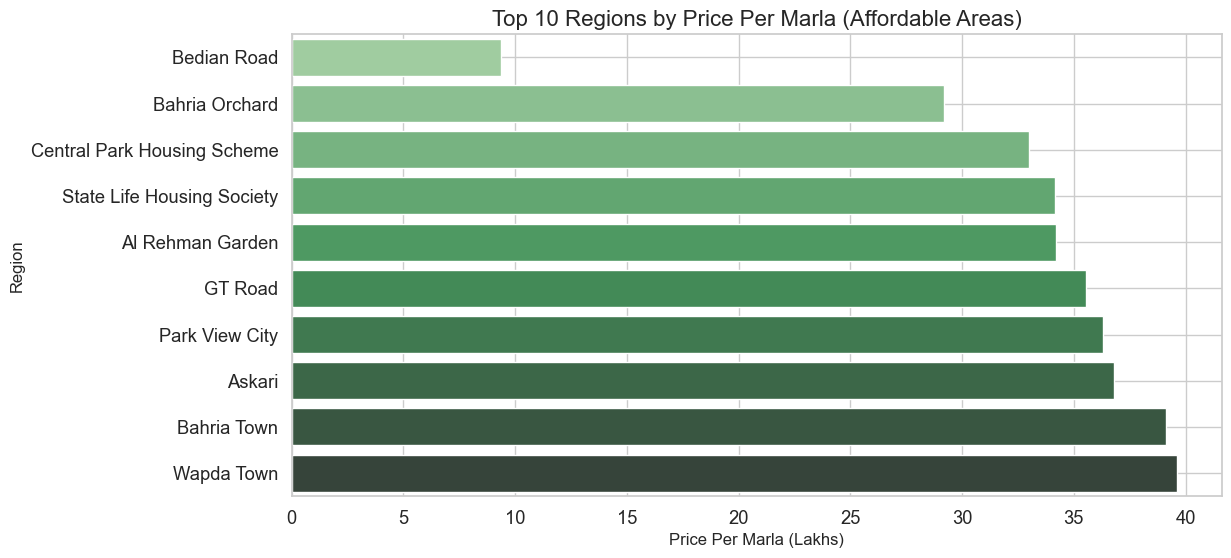

In [ ]:
# 2. Top 10 Regions by Price Per Marla (Affordable Areas)
top_regions_by_price = location_summary.sort_values(by='price_per_marla', ascending=True).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='price_per_marla', y='location', data=top_regions_by_price, palette='Greens_d')
plt.title('Top 10 Regions by Price Per Marla (Affordable Areas)', fontsize=16)
plt.xlabel('Price Per Marla (Lakhs)', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.grid(True)
plt.show()

This analysis identifies the top 10 most affordable regions in Lahore based on the price per marla (land unit). These areas are particularly attractive to buyers seeking cost-effective options. Bedian Road is the most affordable region, with the lowest price per marla, making it ideal for budget-conscious buyers. Other areas like Khayaban-e-Amin and Ferozpur road are also affordable options but Bedian Road is ahead by a significant margin.

Overall, both the plots suggest that areas like DHA Defence and Bahria Town are optimal for sellers looking to capitalize on high demand, while regions such as Bedian Road are ideal for buyers seeking affordability. These insights provide a comprehensive understanding of where buyers and sellers can find the most opportunities in Lahore's real estate market.